## 데이터 불러오기(Fahion MNIST)

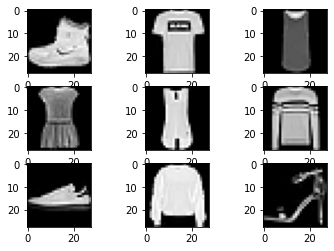

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
n_samples = 100

# load dataset
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

label_dict={
0   :"T-shirt/top",
1	:"Trouser",
2	:"Pullover",
3	:"Dress",
4	:"Coat",
5	:"Sandal",
6	:"Shirt",
7	:"Sneaker",
8	:"Bag",
9	:"Ankle boot"
}


X= images=np.append(x_train,x_test,axis=0)
y=np.append(y_train,y_test,axis=0)
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# 데이터 2차원 array로 변환
(num_samples,num_feat1,num_feat2) = X.shape
num_features = num_feat1 * num_feat2
X = X.reshape(num_samples,-1)
X = X[:n_samples,:]
y = y[:n_samples]
images = images[:n_samples,:]

## 그래프 생성 및 노드 간 거리 행렬 구하기

In [67]:
from sklearn.metrics.pairwise import distance_metrics
import networkx as nx

# k-graph 설정
def set_graph(X:np.array,k:int=None):
    assert k!=None, 'Type the number of neighbors'
    euclidean=distance_metrics()['euclidean']
    dist_matrix = euclidean(X)
    nodes = [i for i in range(len(X))]
    edges_with_weights=[]
    for i in range(len(X)):
        dist_list = dist_matrix[i]
        dist_list_sorted = sorted(dist_list)
        neighbors = []
        for dist in dist_list_sorted[:k]:
            v=np.where(dist_list==dist)[0][0]
            if v != i:
                neighbors.append(v)
        for j in neighbors:
            edges_with_weights.append((i,j,dist_matrix[i][j]))
    G=nx.Graph()
    G.add_weighted_edges_from(edges_with_weights)

    return G, dist_matrix, nodes

# 다익스트라 함수
def dijkstra(G, initial_node):
    visited_dist = {initial_node: 0}
    nodes = set(G.nodes())
    while nodes:
        connected_node = None
        for node in nodes:
            if node in visited_dist:
                if connected_node is None:
                    connected_node = node
                elif visited_dist[node] < visited_dist[connected_node]:
                    connected_node = node
        if connected_node is None:
            break
        nodes.remove(connected_node)
        cur_wt = visited_dist[connected_node]
        for v in dict(G.adj[connected_node]).keys():
            wt = cur_wt + dict(G.adj[connected_node])[v]['weight']
            if v not in visited_dist or wt < visited_dist[v]:
                visited_dist[v] = wt
    return visited_dist

# 다익스트라를 이용한 최종 노드간 거리
def set_distances(G, nodes):
    N = len(nodes)
    final_dist_matrix = np.zeros((N,N))
    for node in nodes:
        visited_dist = dijkstra(G, node)
        for v, dist in visited_dist.items():
            final_dist_matrix[node][v]+=dist
    return final_dist_matrix


## ISOMAP 

In [64]:
from sklearn.decomposition import KernelPCA
import numpy as np

def isomap(distance_matrix, n_components, PCA_config):
    kernel_pca_ = KernelPCA(n_components,**PCA_config)
    Z = (distance_matrix ** 2)*(-0.5)
    embedding = kernel_pca_.fit_transform(Z)
    return embedding

In [ ]:
G, origin_dist_matrix, nodes = set_graph(X,k=10)
final_dist_matrix = set_distances(G,nodes)
pca_config = dict(
    kernel = 'precomputed',
    eigen_solver = 'auto',
    random_state = 42,
    n_jobs = -1
)
isomap_config = dict(
    distance_matrix = final_dist_matrix,
    n_components = 2,
    PCA_config = pca_config
)

isomap_embedding = isomap(**isomap_config)


## 2차원 공간으로의 시각화

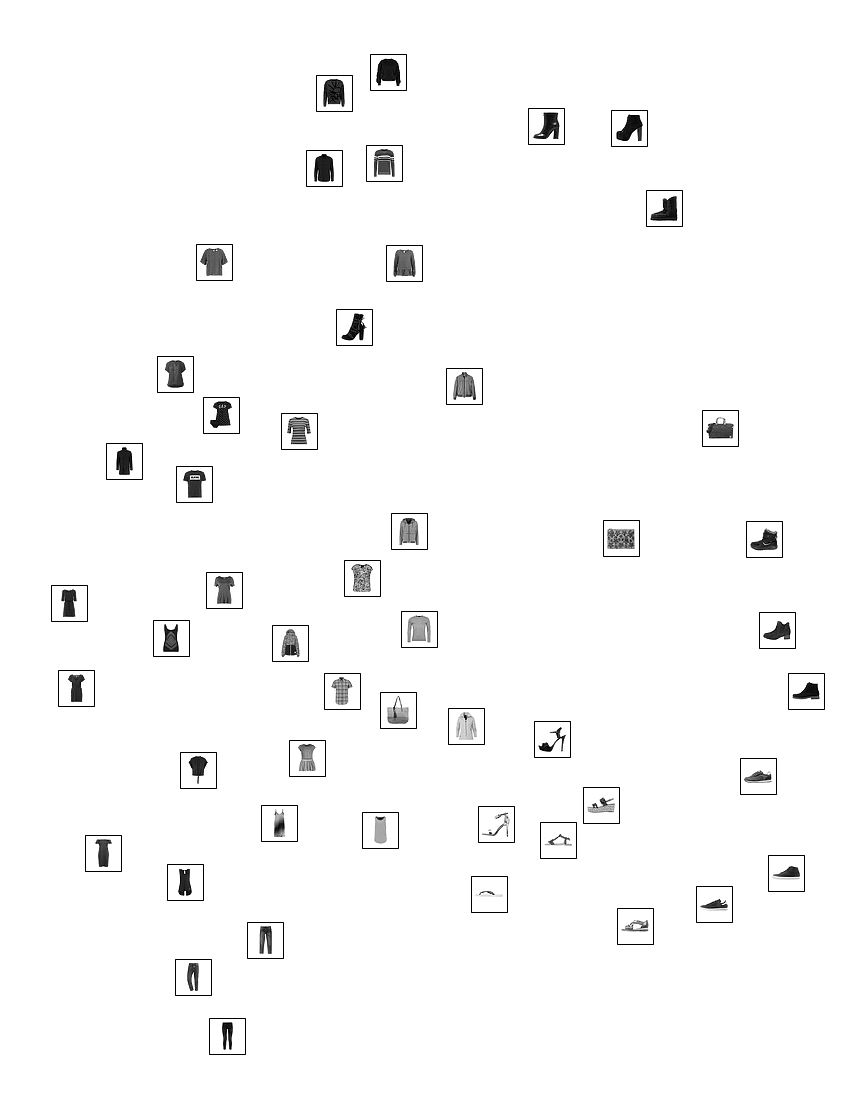

In [84]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

def plot_embedding(title, X, y,label_dict=label_dict,images=images):
    
    _, ax = plt.subplots(figsize=(15,20))
    # ax = plt.figure(figsize=(20,20))
    
    X = MinMaxScaler().fit_transform(X)

    for target_int in label_dict.keys():
        ax.scatter(
            *X[y == target_int].T,
            marker=f"${label_dict[target_int]}$",
            s=1000,
            color=plt.cm.Dark2(target_int),
            alpha=0,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of cloth-types
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)
    
    ax.set_title(title,color='white')
    ax.figure.savefig(f'{title}.png')
    ax.axis("off")

title = f"ISOMAP_with_{k}_neighbors"
plot_embedding(title,isomap_embedding,y,label_dict)